In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("datasets/ext_day_mean_norm_1.csv")
df2 = pd.read_csv("datasets/ext_day_mean_norm_2.csv")
df3 = pd.read_csv("datasets/ext_day_mean_norm_3.csv")
df4 = pd.read_csv("datasets/ext_day_mean_norm_4.csv")

In [3]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

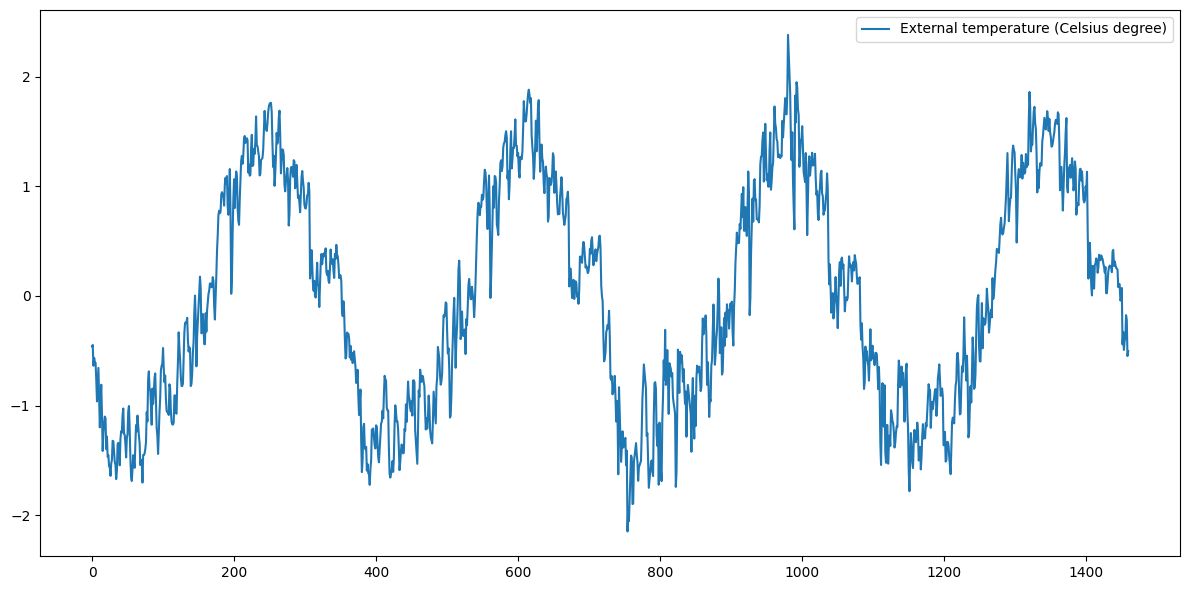

In [4]:
import matplotlib.pyplot as plt

# Plot the last 4 columns
df.plot(subplots=True, figsize=(12, 6))
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to get the seasonal component

result = seasonal_decompose(df['External temperature (Celsius degree)'], model='additive', period=365)
seasonal_trends = result.seasonal
seasonal_trends_year = seasonal_trends[0:365]

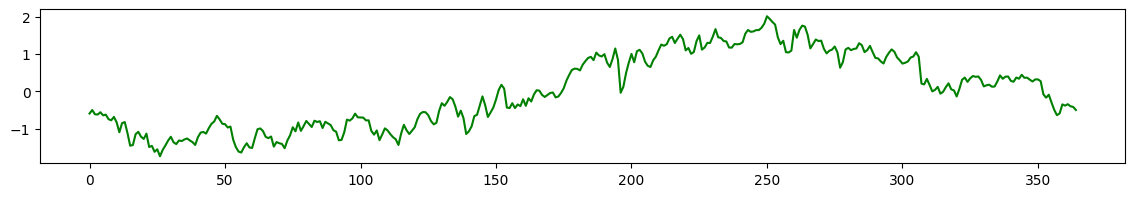

In [102]:
plt.figure(figsize=(14, 2))
plt.plot(seasonal_trends_year, color='green')
plt.show()


In [19]:
residuals = df['External temperature (Celsius degree)'] - seasonal_trends

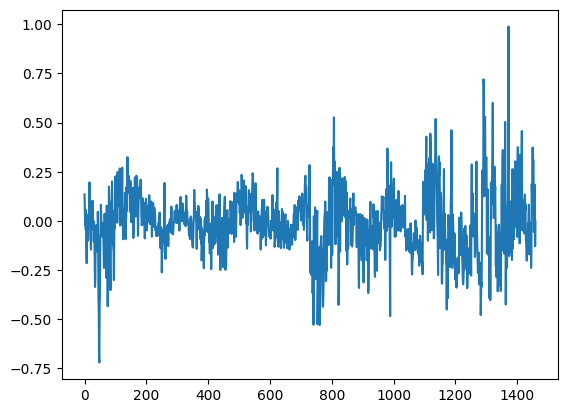

In [21]:
plt.plot(residuals)
plt.show()

In [22]:
import numpy as np
import scipy.stats as stats

def check_and_plot_residuals(residuals):
  """Checks if residuals are normally distributed and plots them against a normal distribution.

  Args:
    residuals: A list of residuals.
  """

  # Convert residuals to a NumPy array
  residuals = np.array(residuals)

  # Check for normality using statistical tests
  # Shapiro-Wilk test for smaller samples
  shapiro_test = stats.shapiro(residuals)
  print("Shapiro-Wilk test:", shapiro_test)

  # Normal Q-Q plot
  stats.probplot(residuals, plot=plt)
  plt.title("Q-Q plot")
  plt.show()

  # Histogram of residuals
  plt.hist(residuals, bins=30, density=True, alpha=0.6, label='Residuals')

  # Overlaying a normal distribution
  mu, std = stats.norm.fit(residuals)
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x, mu, std)
  plt.plot(x, p, 'k', linewidth=2, label='Normal fit')
  plt.legend(loc='best')
  plt.title("Histogram of Residuals with Normal Overlay")
  plt.show()

Shapiro-Wilk test: ShapiroResult(statistic=0.9751296845894949, pvalue=3.4282994194335255e-15)


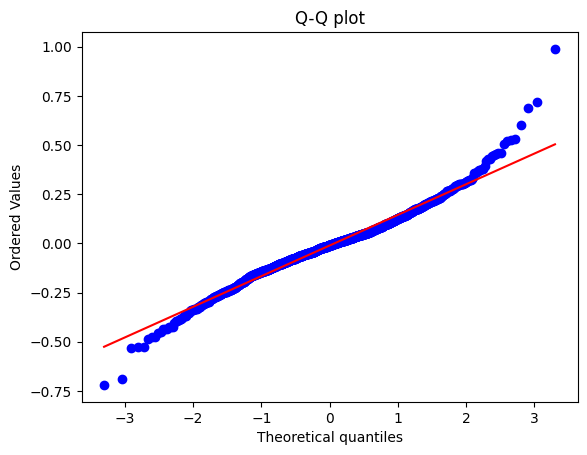

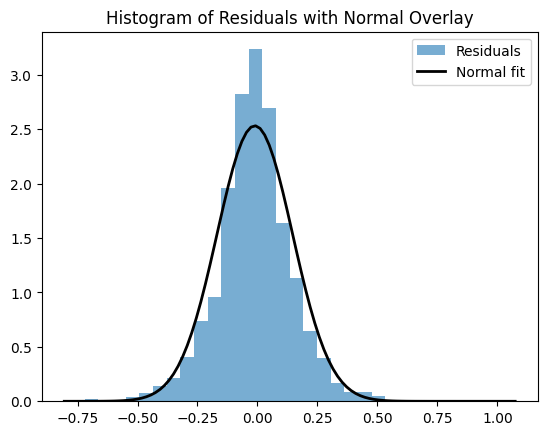

In [23]:
check_and_plot_residuals(residuals)

In [37]:
synthetic_residuals = np.random.choice(residuals, size=365, replace=True)
synthetic_normalized_data = seasonal_trends_year + synthetic_residuals

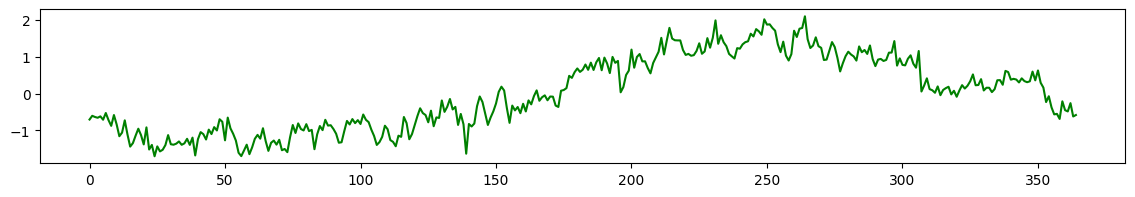

In [103]:


plt.figure(figsize=(14, 2))
plt.plot(synthetic_normalized_data, color='green')
plt.show()

In [40]:
ms = pd.read_csv("datasets/ext_day_mean_std.csv")

In [56]:
means = ms['mean'].to_list()
stds = ms['std'].to_list()

In [57]:
import random

In [59]:
sampled_mean = random.choice(means)
sampled_std = random.choice(stds)

In [62]:
synthetic_data = (synthetic_normalized_data * sampled_std) + sampled_mean

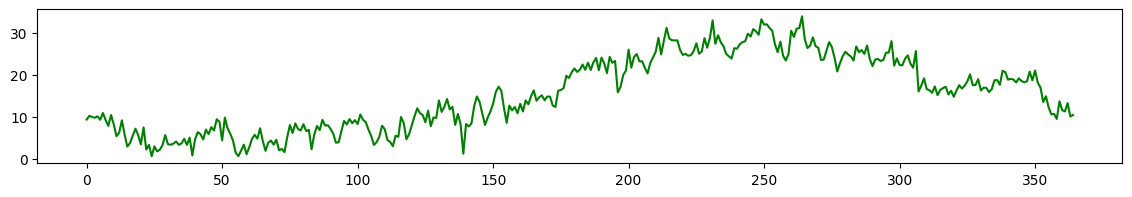

In [101]:
plt.figure(figsize=(14, 2))
plt.plot(synthetic_data, color='green')
plt.show()

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

In [68]:
class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 1, hidden_dim),  # noise_dim + 1 for avg_temp
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, output_dim)  # Output 96 values
        )
    
    def forward(self, noise, avg_temp):
        avg_temp = avg_temp.view(-1, 1)  # Ensure avg_temp is the right shape
        x = torch.cat((noise, avg_temp), dim=1)
        return self.model(x)

In [70]:
device = 'cpu'

# Load the entire model object
GAN_model = torch.load('models/GAN_model.pth', map_location=torch.device(device))

/tmp/ipykernel_24175/3494014465.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GAN_model = torch.load('models/GAN_model.pth', map_location=torch.device(device))


In [76]:
# Generate new timeseries
noise_dim = 64

GAN_model.eval()
with torch.no_grad():
    noise = torch.randn(len(synthetic_data), noise_dim, device=device)
    avg_temp = torch.tensor([[element] for element in synthetic_data], device=device)
    generated_timeseries = GAN_model(noise, avg_temp)
    print(generated_timeseries)

tensor([[ 7.6916,  7.7275,  7.6705,  ...,  8.4104,  8.3973,  8.4425],
        [ 8.0008,  8.0364,  7.9719,  ...,  8.7469,  8.7612,  8.7903],
        [ 7.8164,  7.8336,  7.7672,  ...,  8.5240,  8.5477,  8.5625],
        ...,
        [11.0506, 11.0894, 11.0782,  ..., 12.2025, 12.1853, 12.1874],
        [ 8.1299,  8.1498,  8.1278,  ...,  8.9395,  8.9467,  8.9486],
        [ 8.5059,  8.5443,  8.5360,  ...,  9.4129,  9.4482,  9.4176]])


In [77]:
generated_timeseries.shape

torch.Size([365, 96])

In [86]:
ts_list = generated_timeseries.flatten().tolist()

In [87]:
len(ts_list)

35040

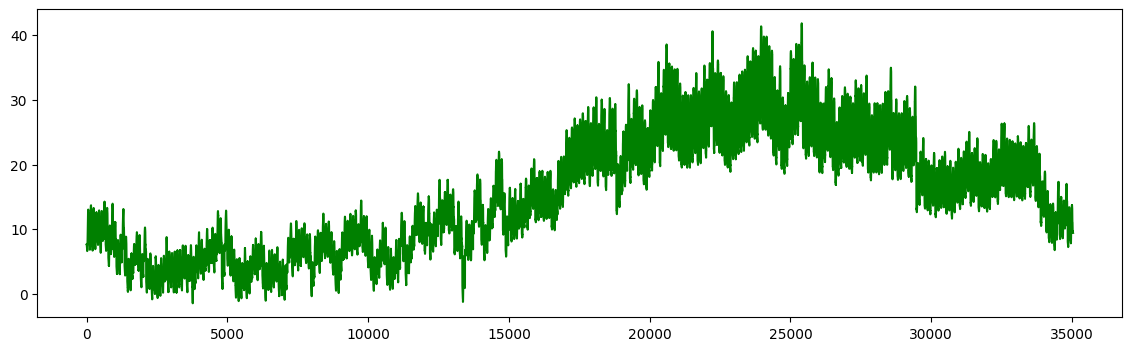

In [106]:

plt.figure(figsize=(14, 4))
plt.plot(ts_list, color='green')
plt.show()